# Benjamin Lavoie (benjaminlavoie02@gmail.com)

# CapStone project: Gaming Score Forecasting Model

# Last update: March 14th, 2024 (version 2.0)

# Notebook 2: Pre-processing and Processing

# Table of Contents

**[1. Part 1 - Inspecting and choosing datasets](#heading--1)**

  * [1.1 - Dataset VG_Sales_All2](#heading--1-1)

  * [1.2 - Dataset Video_Games](#heading--1-2)
  
  * [1.3 - Dataset metacritic_games_master](#heading--1-3)
    
  * [1.4 - Dataset Tagged-Data-Final](#heading--1-4)
  
  * [1.5 - Dataset Cleaned Data 2](#heading--1-5)
  
  * [1.6 - Dataset opencritic_rankings_feb_2023](#heading--1-6)
  
  * [1.7 - Dataset vgsales](#heading--1-7)
  
  * [1.8 - Dataset all_video_games(cleaned)](#heading--1-8)
  
  * [1.9 - Dataset Raw Data](#heading--1-9)
  

**[2. Part 2 - Cleaning and joining datasets](#heading--2)**

  * [2.1 - Merging the 4 main datasets](#heading--2-1)


## [Next Steps](#heading--3)


In [22]:

# Necessary libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import nltk
import statsmodels.api as sm
import glob
import os
from scipy.stats import chi2_contingency

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# To plot
from scipy import stats
from scipy.stats import norm 

# To split the data as necessary for modelling
from sklearn.model_selection import train_test_split

# To process text data
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import string

# To get rid of logistic regression default solver warnings that appear if sklearn hasn't been updated
import warnings
warnings.filterwarnings('ignore')

# To "pickle" things, like accuracies or even an entire fitted model
import joblib

# To cross-validate
from sklearn.model_selection import cross_val_score

# To set up a temporary directory for caching pipeline results
from tempfile import mkdtemp

# To build a pipeline
from sklearn.pipeline import Pipeline

# To do dimensionality reduction
from sklearn.decomposition import PCA

# To do a cross-validated grid search
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer


# To see more columns at once, I'll change the display.max_columns number
pd.set_option('display.max_columns', 50)

## Introduction (2nd Notebook)

The cleaning and the EDA has all been done in the 1st Notebook.

In this 2nd Notebook, I will be doing the pre-processing as well as the processing/modeling.

I will start importing the data set, and then by separating the dataset. Since I have 14k+ rows and not 100k+ rows, I'll keep only 30% for the testing.

In [203]:
df = pd.read_csv('clean_data_2.0.csv', index_col='Unnamed: 0', header=0)

In [204]:
df.head(5)

,Name,Platform,Publisher,Developer,Genre,Platform_Brand,Platform_Type,Release_Date,Release_Day,Release_Month,Release_Year,Metascore_Range
0,Wii Sports,Wii,Nintendo,Nintendo EAD,Sports,Nintendo,HomeConsole,2006-11-19,19,11,2006,Okay
1,Mario Kart 8 Deluxe,NS,Nintendo,Nintendo EPD,Racing,Nintendo,HomeConsole,2017-04-28,28,4,2017,Strong
2,Team Fortress 2,PC,Valve,Valve Corporation,Shooter,PC,PC,2007-10-10,10,10,2007,Strong
3,Counter-Strike: Global Offensive,PC,Valve,Valve Corporation,Shooter,PC,PC,2012-08-21,21,8,2012,Strong
4,Counter-Strike: Global Offensive,PC,Valve,Valve Corporation,Shooter,PC,PC,2015-10-23,23,10,2015,Strong


Let's separate the data in train and test sets.

In [222]:
# separating into X and y

X = df.drop(columns="Metascore_Range")
y = df["Metascore_Range"]


# Separating into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

# resetting the indexes to be able to separate the review columns and concatenate them easily later
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


# Print info on how the data has been split
print(f'The TRAIN set has {len(X_train)} data points.')
print(f'The TEST set has {len(X_test)} data points.')

The TRAIN set has 10064 data points.
The TEST set has 4314 data points.


In [223]:
# for col1 in X_train.columns:
#     for col2 in X_train.columns:
#         if col1 != col2:
#             contingency_table = pd.crosstab(X_train[col1], X_train[col2])
#             chi2, p, _, _ = chi2_contingency(contingency_table)
#             if (p > 1e-10):
#                 print(f'Chi-square test between {col1} and {col2}: Chi2={chi2}, p-value={p}')

One hot encoding:


In [224]:
X_train_numerical = X_train[['Platform', 'Genre', 'Platform_Brand', 'Platform_Type']].copy()
X_train_dummy = pd.get_dummies(X_train_numerical, dtype=np.int32)

X_test_numerical = X_test[['Platform', 'Genre', 'Platform_Brand', 'Platform_Type']].copy()
X_test_dummy = pd.get_dummies(X_test_numerical, dtype=np.int32)

X_train = pd.concat([X_train, X_train_dummy], axis="columns")
X_test = pd.concat([X_test, X_test_dummy], axis="columns")

X_train.drop(['Platform', 'Genre', 'Platform_Brand', 'Platform_Type'], axis = 1, inplace=True)
X_test.drop(['Platform', 'Genre', 'Platform_Brand', 'Platform_Type'], axis = 1, inplace=True)

In [225]:
print(X_train_numerical.shape)
print(X_train_dummy.shape)
print(X_test_numerical.shape)
print(X_test_dummy.shape)
print(X_train.shape)
print(X_test.shape)
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())

(10064, 4)
(10064, 46)
(4314, 4)
(4314, 46)
(10064, 53)
(4314, 53)
0
0


In [226]:
X_train.columns

Index(['Name', 'Publisher', 'Developer', 'Release_Date', 'Release_Day',
       'Release_Month', 'Release_Year', 'Platform_3DS', 'Platform_DS',
       'Platform_GBA', 'Platform_GC', 'Platform_N64', 'Platform_NS',
       'Platform_PC', 'Platform_PS', 'Platform_PS2', 'Platform_PS3',
       'Platform_PS4', 'Platform_PS5', 'Platform_PSP', 'Platform_PSV',
       'Platform_Wii', 'Platform_WiiU', 'Platform_X360', 'Platform_XB',
       'Platform_XOne', 'Platform_XS', 'Genre_Action',
       'Genre_Action-Adventure', 'Genre_Adventure', 'Genre_Board Game',
       'Genre_Fighting', 'Genre_MMO', 'Genre_Misc', 'Genre_Music',
       'Genre_Party', 'Genre_Platform', 'Genre_Puzzle', 'Genre_Racing',
       'Genre_Role-Playing', 'Genre_Sandbox', 'Genre_Shooter',
       'Genre_Simulation', 'Genre_Sports', 'Genre_Strategy',
       'Genre_Visual Novel', 'Platform_Brand_Microsoft',
       'Platform_Brand_Nintendo', 'Platform_Brand_PC', 'Platform_Brand_Sony',
       'Platform_Type_Handheld', 'Platform_Type_Hom

Because I think that using a NLP, I will use TF DIF to create more features. Then, I will be able to continue the processing

## Columns to vectorize with TFDIF

In [227]:
stemmer = nltk.stem.PorterStemmer()

ENGLISH_STOP_WORDS = stopwords.words('english')

# Custom stopwords to be added
custom_stopwords = ['game', 'games', 'unknown', 'studio', 'inc', 'ltd']

# Extend stopwords with custom stopwords
ENGLISH_STOP_WORDS.extend(custom_stopwords)

# my_tokenizer function, to be used when vectorizing
def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

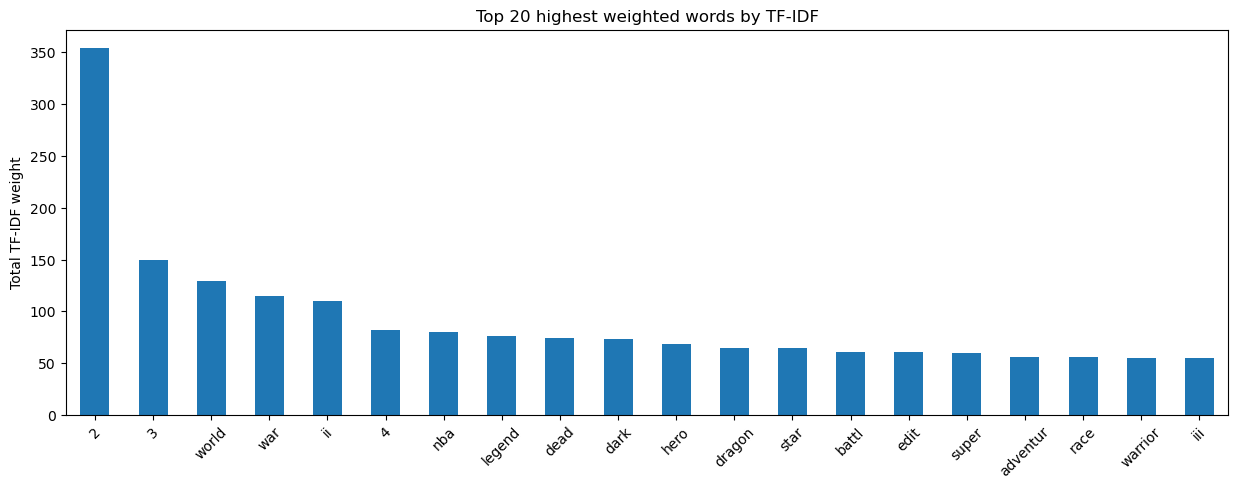

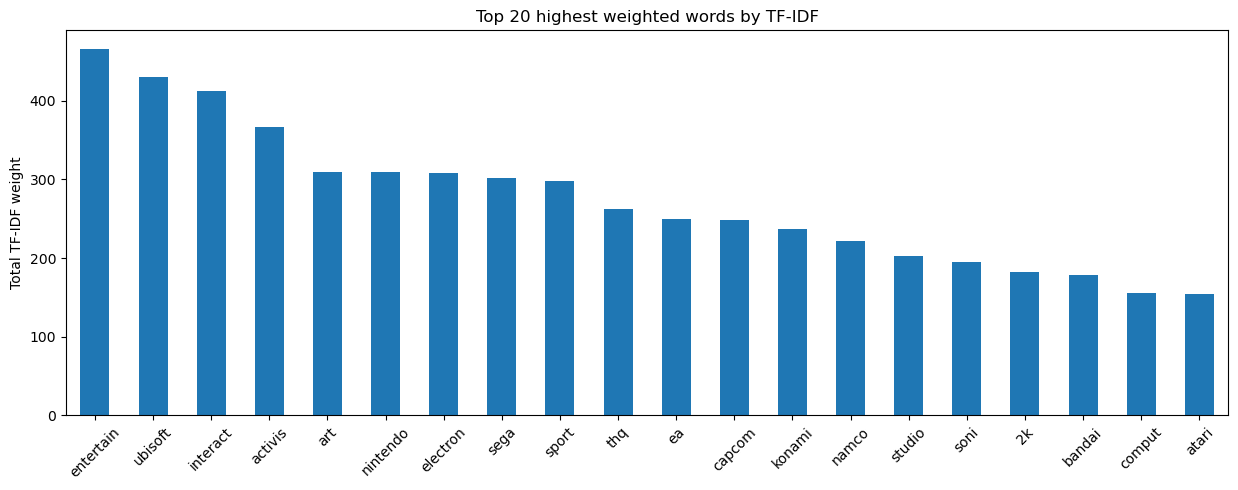

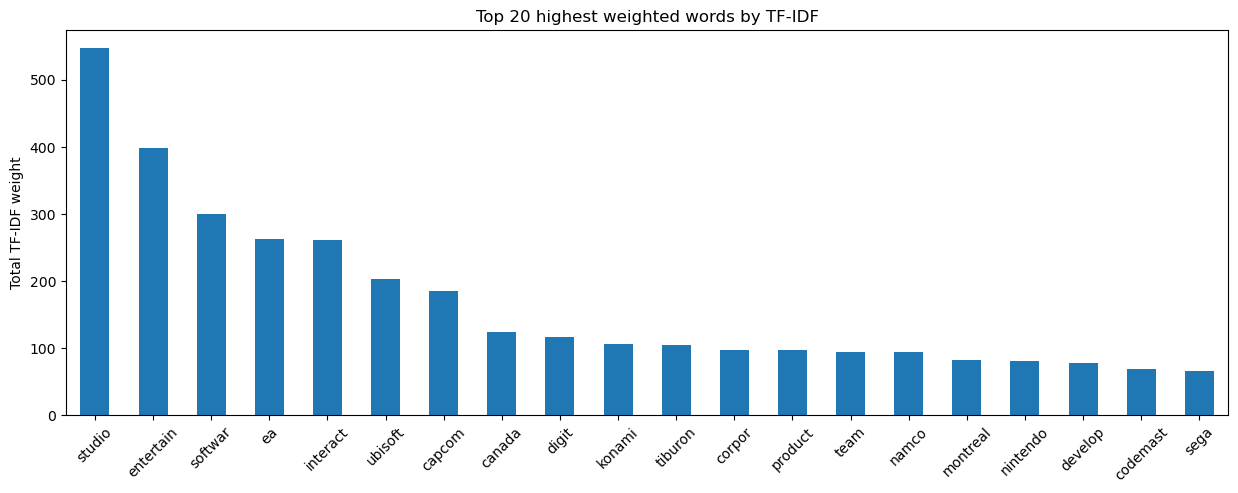

0
0
(10064, 1178)
(4314, 1178)


In [228]:
tfidf_columns = ['Name', 'Publisher', 'Developer']

tfidf_dfs = []
X_train_keep = pd.DataFrame()

for col in tfidf_columns:

    tfidf = TfidfVectorizer(tokenizer = my_tokenizer, min_df=10)

    # Fit and transform the text data
    transformed_train = tfidf.fit_transform(X_train[col])
    transformed_test = tfidf.transform(X_test[col])
    
    # store my vectorizers
    tfidf_dfs.append(tfidf)

    # Convert the transformed data into a dataframe
    tfidf_df_train = pd.DataFrame(transformed_train.toarray(),
                                   columns=tfidf.get_feature_names_out())

    tfidf_df_test = pd.DataFrame(transformed_test.toarray(),
                                   columns=tfidf.get_feature_names_out())


    # Join the 2 tfidf_df with the 2 dfs
    tfidf_df_train = tfidf_df_train.add_prefix(f'{col}_')
    tfidf_df_test = tfidf_df_test.add_prefix(f'{col}_')
    X_train = pd.concat([X_train, tfidf_df_train], axis="columns")
    X_test = pd.concat([X_test, tfidf_df_test], axis="columns")
    
    X_train_keep[col] = X_train[col]
    
    X_train.drop(col, axis = 1, inplace=True)
    X_test.drop(col, axis = 1, inplace=True)
    
    word_counts = pd.DataFrame(
        {"counts": transformed_train.toarray().sum(axis=0)},
        index=tfidf.get_feature_names_out()
    ).sort_values("counts", ascending=False)

    word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
    plt.title("Top 20 highest weighted words by TF-IDF")
    plt.ylabel("Total TF-IDF weight")
    plt.xticks(rotation=45)
    plt.show()

# checking for null values and the shapes
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())
print(X_train.shape)
print(X_test.shape)

In [182]:
X_train.head()

,Release_Date,Release_Day,Release_Month,Release_Year,Platform_3DS,Platform_DS,Platform_GBA,Platform_GC,Platform_N64,Platform_NS,Platform_PC,Platform_PS,Platform_PS2,Platform_PS3,Platform_PS4,Platform_PS5,Platform_PSP,Platform_PSV,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne,Platform_XS,Genre_Action,...,Developer_treasure,Developer_treyarch,Developer_tri,Developer_tt,Developer_two,Developer_ubisoft,Developer_unknown,Developer_valve,Developer_vancouver,Developer_vicarious,Developer_vicious,Developer_view,Developer_vision,Developer_visions,Developer_visual,Developer_volition,Developer_voltage,Developer_wales,Developer_ward,Developer_way,Developer_wayforward,Developer_works,Developer_world,Developer_worlds,Developer_yuke
0,2009-06-16,16,6,2009,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2002-06-13,13,6,2002,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-02-15,15,2,2019,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-11-04,4,11,2013,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-04-19,19,4,2013,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [183]:
print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10064 entries, 0 to 10063
Columns: 1201 entries, Release_Date to Developer_yuke
dtypes: float64(1151), int32(46), int64(3), object(1)
memory usage: 90.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4314 entries, 0 to 4313
Columns: 1201 entries, Release_Date to Developer_yuke
dtypes: float64(1151), int32(46), int64(3), object(1)
memory usage: 38.8+ MB
None


Before modeling, dropping one last column:

In [230]:
X_train.drop('Release_Date', axis = 1, inplace=True)
X_test.drop('Release_Date', axis = 1, inplace=True)

In [231]:
print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10064 entries, 0 to 10063
Columns: 1177 entries, Release_Day to Developer_zaxi
dtypes: float64(1128), int32(46), int64(3)
memory usage: 88.6 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4314 entries, 0 to 4313
Columns: 1177 entries, Release_Day to Developer_zaxi
dtypes: float64(1128), int32(46), int64(3)
memory usage: 38.0 MB
None


Pipeline:

In [ ]:
%%time

# Baseline logistic regression

# Instantiate and fit to the remainder set
baseline_logreg = LogisticRegression(max_iter=10000, n_jobs=-1).fit(X_train, y_train)


# Print the accuracies
print(f'Accuracy on test set: {baseline_logreg.score(X_test, y_test)}')
